<a href="https://colab.research.google.com/github/griffstaples/PDE_Transfer_Colab/blob/main/notebooks/visualization_mc_ape2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install --quiet pdetransformer

## Initialize PDE-S with pretrained weights from huggingface

In [14]:
from pdetransformer.core.mixed_channels import PDETransformer, SingleStepSupervised
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained model
model = PDETransformer.from_pretrained('thuerey-group/pde-transformer', subfolder='mc-s').to(device)
strategy = SingleStepSupervised(model)

## Load dataset

In [15]:
from pdetransformer.data import MultiDataModule

dataset = 'kolm_flow'
dataset_name = 'Kolmogorov Flow'
field = 'Vorticity'

params_data = {
    'path_index':
        {'2D_APE_xxl': './datasets'},
    'dataset_names': [ dataset ],
    'dataset_type': '2D_APE_xxl',
    'unrolling_steps': 1,
    'test_unrolling_steps': 29,
    'batch_size': 1,
    'num_workers': 1,
    'cache_strategy': 'none',
    'different_resolution_strategy': 'none',
    'normalize_data': 'mean-std',
    'normalize_const': 'mean-std',
    'downsample_factor': 1,
    'max_channels': 2,
}

data_module = MultiDataModule(**params_data)
data_module.setup(stage='test')
test_loader = data_module.test_dataloader()

Success: Loaded kolm_flow with 60 simulations and 29 samples each.
Success: Loaded kolm_flow_test with 5 simulations and 1 samples each.


In [16]:
data = next(iter(test_loader))
prediction, reference = strategy.predict(data, device=device, num_frames=29)

100%|██████████| 28/28 [00:35<00:00,  1.26s/it]


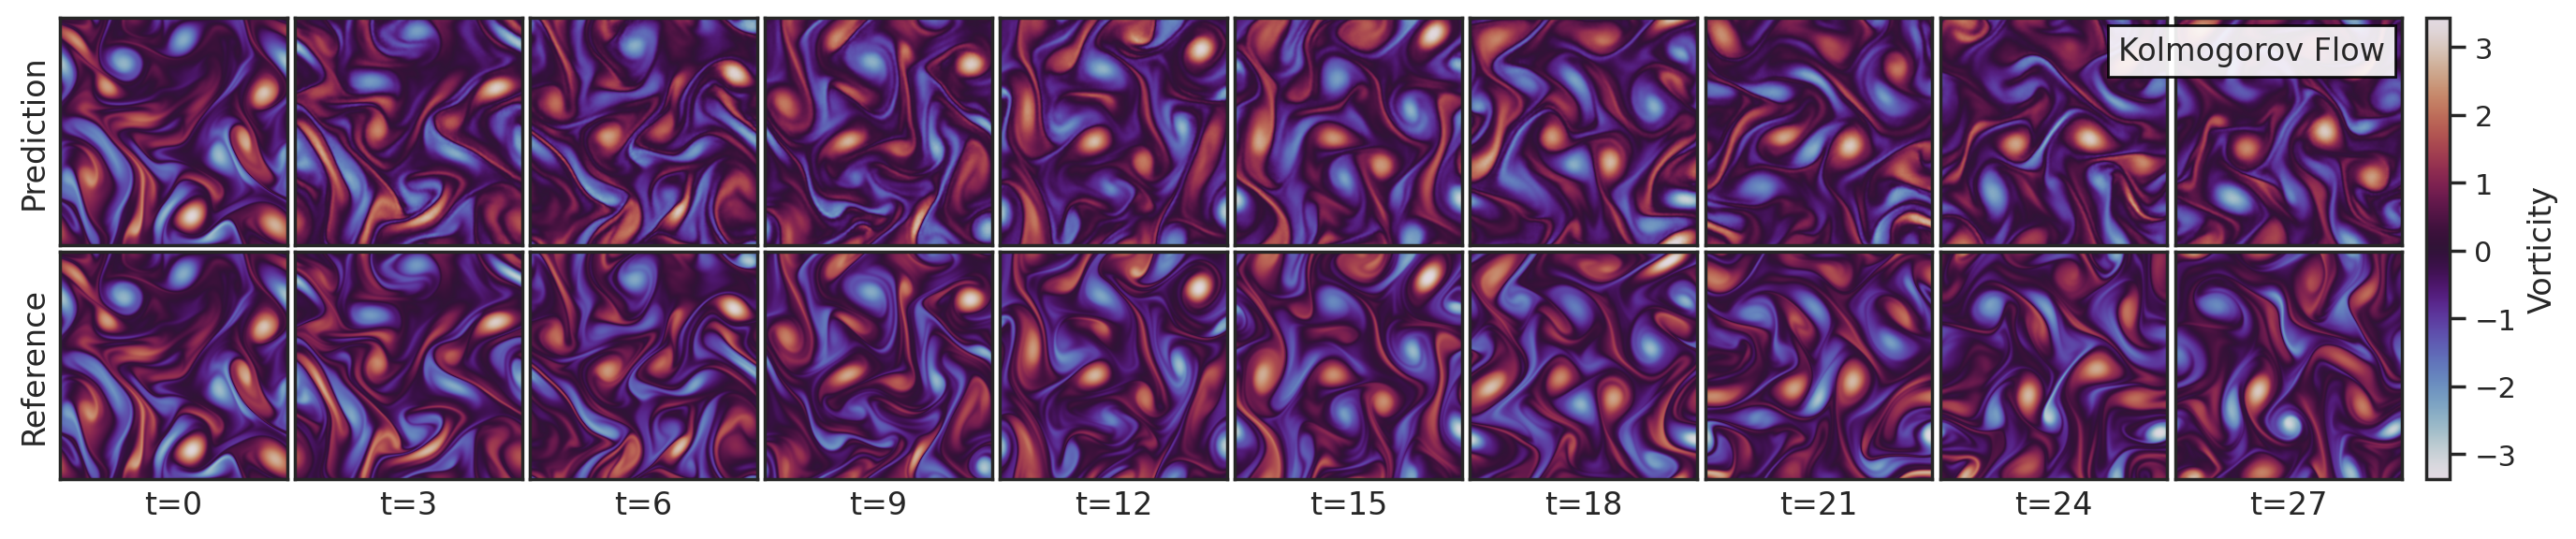

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

time_steps = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

prediction_steps = prediction[0, :, :, :]
reference_steps = reference[0, :, :, :]

sns.set_theme(style="white")
cmap = sns.color_palette("twilight", as_cmap=True)

fig, axes = plt.subplots(2, len(time_steps), figsize=(16.65,3.2), dpi=200)

vmin = reference_steps.min()
vmax = reference_steps.max()

for j, t in enumerate(time_steps):

    axes[0, j].imshow(prediction_steps[t][0],  cmap=cmap, vmin=vmin, vmax=vmax)

    axes[0, j].set_xticks([])
    axes[0, j].set_yticks([])

    axes[1, j].imshow(reference_steps[t][0], cmap=cmap,
                        vmin=vmin, vmax=vmax)

    axes[1, j].set_xticks([])
    axes[1, j].set_yticks([])

axes[0, 0].set_ylabel('Prediction', fontsize=12)
axes[1, 0].set_ylabel('Reference', fontsize=12)

for j, t in enumerate(time_steps):
    axes[1, j].set_xlabel(f't={t}', fontsize=12)

fig.text(0.8712, 0.85, f'{dataset_name}',
            fontsize=12, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))

plt.subplots_adjust(wspace=0.03, hspace=0.03)

cbar = fig.colorbar(axes[0, 0].images[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label(field, fontsize=12)

plt.show()

## Model input for single step

In [24]:
input_0, input_1, labels = strategy.get_input(data)

In [19]:
labels

tensor([16])

Class label 16 corresponds to Kolmogorov flow

In [20]:
print('input_0: ', input_0.shape)
print('input_1: ', input_1.shape)

input_0:  torch.Size([1, 2, 256, 256])
input_1:  torch.Size([1, 29, 2, 256, 256])


We can also drop the class label and let the modle infer the type of PDE by itself

In [21]:
labels_unknown = torch.ones_like(labels) * 1000

In [22]:
with torch.no_grad():

    output_kolm_flow = model(
        hidden_states=input_0.to(device),
        class_labels=labels.to(device)
    )

    output_unknown = model(
        hidden_states=input_0.to(device),
        class_labels=labels_unknown.to(device)
    )

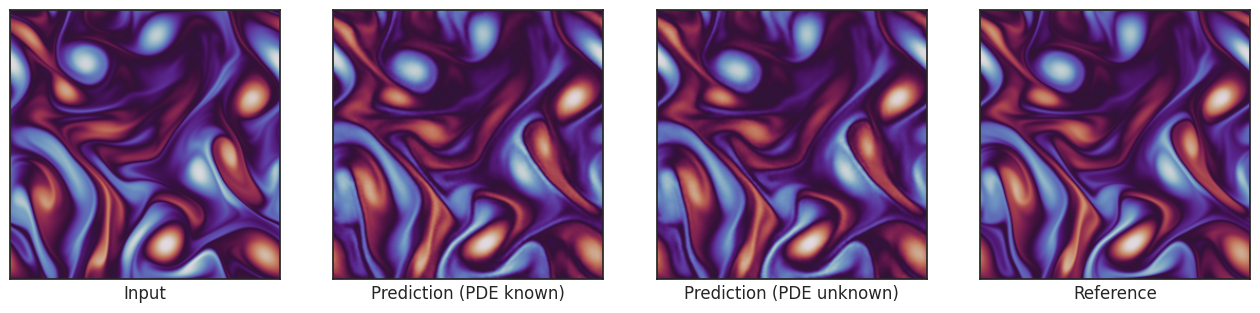

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

vmin = input_0.min()
vmax = input_1.max()

axes[0].imshow(input_0[0,0].numpy(), cmap='twilight')
axes[0].set_xlabel('Input')

axes[1].imshow(output_kolm_flow.sample[0,0].detach().cpu().numpy(), cmap='twilight')
axes[1].set_xlabel('Prediction (PDE known)')

axes[2].imshow(output_unknown.sample[0,0].detach().cpu().numpy(), cmap='twilight')
axes[2].set_xlabel('Prediction (PDE unknown)')

axes[3].imshow(input_1[0,0,0].numpy(), cmap='twilight')
axes[3].set_xlabel('Reference')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [25]:
# Generate random data
random_kolm_flow_data = torch.randn(1, 2, 256, 256).to(device)

# Generate class labels for Kolmogorov flow (assuming 16 is the correct label based on the previous output)
kolm_flow_labels = torch.ones(1).long().to(device) * 16

# Make predictions for multiple steps
num_prediction_steps = 10  # You can change this number
predictions = [random_kolm_flow_data]
with torch.no_grad():
    current_input = random_kolm_flow_data
    for _ in range(num_prediction_steps):
        prediction = model(
            hidden_states=current_input,
            class_labels=kolm_flow_labels
        )
        predictions.append(prediction.sample)
        current_input = prediction.sample

predictions = torch.cat(predictions, dim=0)

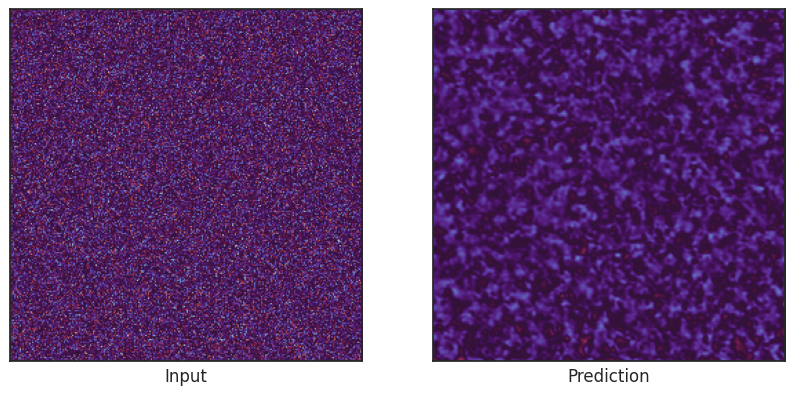

In [26]:
# Plot the input and predicted output
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

vmin = random_kolm_flow_data.min()
vmax = random_kolm_flow_data.max()

axes[0].imshow(random_kolm_flow_data[0, 0].cpu().numpy(), cmap='twilight', vmin=vmin, vmax=vmax)
axes[0].set_xlabel('Input')

axes[1].imshow(prediction[-1].sample[0, 0].detach().cpu().numpy(), cmap='twilight', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('Prediction')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()